# INFO about the Data

The data sets used in this example, along with all necessary information such as the list of related worls, are available in the [NASA Prognostics data archive](https://data.nasa.gov/dataset/Turbofan-engine-degradation-simulation-data-set/vrks-gjie). Original data is available with this [link](http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-data-repository/#turbofan)

![title](image/engine.png)

<center>
<a href=https://ntrs.nasa.gov/citations/20070034949>Simplified diagram of engine simulated in C-MAPSS</a>
</center>

This data set is simulated by the tool Commercial Modular Aero Propulsion System Simulation (C-MAPSS) developed by NASA. Run-to-failure simulations were performed for engines with varying degrees of initial wear but in a healthy state. During each cycle in the simulation, one sample of all 21 sensors such as the physical core speed, the temperature at fan inlet and the pressure at fan inlet etc. will be recorded once. As the simulation progresses, the performance of the turbofan
engine degrades until it loses functionality. C-MAPSS data consists of four sub-data sets with different operational conditions and fault patterns as shown below.

| Data Set | Train trajectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |


Each sub-data set has been split into a training set and a test set. The training sets contain sensor records for all cycles in the run-to-failure simulation. Unlike the training sets, the test sets only contain partial temporal sensor records which stopped at a time prior to the failure. The task is to predict the RUL of each engine in the test sets by using the training sets with the given sensor records. The corresponding RUL to test sets has been provided. With this, the performance of the model can be verified. It should be noted that the four sub-data sets are of varying complexity.


26 columns are listed as below

| Column| Description | Units | 
|----------|:-----------------:|------------------:|
| 1    |        unit number        |   --   |
| 2    |        time, in cycles        |     --   |
| 3    |        operational setting 1        |  --   | 
| 4    |        operational setting 2        |  --   |           
| 5    |        operational setting 3        |  --   |         
| 6    | Total temperature at fan inlet  | °R    |  
| 7    | Total temperature at LPC outlet  | °R    |  
| 8    | Total temperature at HPC outlet  | °R    |  
| 9    | Total temperature at LPT outlet  | °R    |  
| 10    | Pressure at fan inlet  | psia    |  
| 11    | Total pressure in bypass-duct  | psia   |   
| 12    | Total pressure at HPC outlet  | psia    |  
| 13    | Physical fan speed  | rpm    |  
| 14    | Physical core speed  | rpm    |  
| 15    | Engine pressure ratio (P50/P2)  | --    |  
| 16    | Static pressure at HPC outlet  | psia    |  
| 17    | Ratio of fuel flow to Ps30  | pps/psi   |  
| 18     |Corrected fan speed  | rpm    |  
| 19    | Corrected core speed  | rpm    |  
| 20    | Bypass Ratio  | --    |  
| 21    | Burner fuel-air ratio  | --    |  
| 22    | Bleed Enthalpy  | --   |  
| 23   | Demanded fan speed | rpm  |
| 24   | Demanded corrected fan speed | rpm  |
| 25   | HPT coolant bleed | lbm/s  |
| 26   | LPT coolant bleed | lbm/s |

# import packages

In [24]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error

from ECLSTM import ECLSTM1D,check_the_config_valid,build_the_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,TimeDistributed,LSTM
import tensorflow.keras.callbacks as callback
pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16

# DATA PREPARATION
## Load the training data and test data

In [25]:
# For simplicity, each column is named with S (sensor) + number
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']



# Data_id can be defined as FD001, FD002, FD003 and FD004
Data_id = "FD004"

train_FD = pd.read_table("./data/C-MAPSS/train_{}.txt".format(Data_id), header=None, delim_whitespace=True)
train_FD.columns = column_name


test_FD = pd.read_table("./data/C-MAPSS/test_{}.txt".format(Data_id), header=None, delim_whitespace=True)
test_FD.columns = column_name

RUL_FD = pd.read_table("./data/C-MAPSS/RUL_{}.txt".format(Data_id), header=None, delim_whitespace=True)

In [26]:
train_FD.describe()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000,61249.00000
mean,124.32518,134.31142,23.99982,0.57135,94.03158,472.88244,579.42006,1417.89660,1201.91536,8.03163,11.58946,283.32863,2228.68603,8524.67330,1.09645,42.87453,266.73567,2334.42759,8067.81181,9.28560,0.02325,347.76003,2228.61328,97.75140,20.86433,12.51900
std,71.99535,89.78339,14.78072,0.31070,14.25195,26.43683,37.34265,106.16760,119.32759,3.62287,5.44402,146.88021,145.34824,336.92755,0.12768,3.24349,138.47911,128.19786,85.67054,0.75037,0.00468,27.80828,145.47249,5.36942,9.93640,5.96270
min,1.00000,1.00000,0.00000,0.00000,60.00000,445.00000,535.48000,1242.67000,1024.42000,3.91000,5.67000,136.17000,1914.72000,7984.51000,0.93000,36.04000,128.31000,2027.57000,7845.78000,8.17570,0.02000,302.00000,1915.00000,84.93000,10.16000,6.08430
25%,60.00000,62.00000,10.00460,0.25070,100.00000,445.00000,549.33000,1350.55000,1119.49000,3.91000,5.72000,142.92000,2211.95000,8320.59000,1.02000,41.76000,134.52000,2387.91000,8062.63000,8.64800,0.02000,330.00000,2212.00000,100.00000,10.94000,6.56610
50%,126.00000,123.00000,25.00140,0.70000,100.00000,462.54000,555.74000,1367.68000,1136.92000,7.05000,9.03000,194.96000,2223.07000,8362.76000,1.03000,42.33000,183.45000,2388.06000,8083.81000,9.25560,0.02000,334.00000,2223.00000,100.00000,14.93000,8.96010
75%,185.00000,191.00000,41.99810,0.84000,100.00000,491.19000,607.07000,1497.42000,1302.62000,10.52000,15.48000,394.28000,2323.93000,8777.25000,1.26000,45.22000,371.40000,2388.17000,8128.35000,9.36580,0.03000,368.00000,2324.00000,100.00000,28.56000,17.13550
max,249.00000,543.00000,42.00800,0.84200,100.00000,518.67000,644.42000,1613.00000,1440.77000,14.62000,21.61000,570.81000,2388.64000,9196.81000,1.32000,48.36000,537.49000,2390.49000,8261.65000,11.06630,0.03000,399.00000,2388.00000,100.00000,39.89000,23.88520


# Compute the remaining useful life

### RUL for Training dataset

Here, we use the piecewise linear degradation model as the target function in the estimation process. 
The degradation of the system typically starts after a certain degree of usage, and hence, we consider this model to be more suited compared to the linear degradation model. [1](https://arxiv.org/abs/1810.05644)
![title](image/piecewise.png)

In [27]:
# piecewise linear RUL  Maximal life is defined as 120

id='engine_id'
MAXLIFE = 120 
rul = [] 
for _id in set(train_FD[id]):
    trainFD_of_one_id =  train_FD[train_FD[id] == _id]
    cycle_list = trainFD_of_one_id['cycle'].tolist()
    max_cycle = max(cycle_list)

    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)
    rul.extend(kink_RUL)

train_FD["RUL"] = rul

### RUL for test dataset

In [28]:
id='engine_id'
rul = []
for _id_test in set(test_FD[id]):
    true_rul = int(RUL_FD.iloc[_id_test - 1])
    testFD_of_one_id =  test_FD[test_FD[id] == _id_test]
    cycle_list = testFD_of_one_id['cycle'].tolist()
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = max_cycle-i-1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD["RUL"] = rul

# Feature extention

    Remove features that have only unique value
    
    Use correlation test methods (Significance test) to exclude features that are not related to the target variable

In [29]:
col_to_drop = identify_and_remove_unique_columns(train_FD)

In [30]:
train_FD = train_FD.drop(col_to_drop,axis = 1)

In [31]:
test_FD = test_FD.drop(col_to_drop,axis = 1)

## Normalization 

In [32]:
mean_of_train = train_FD.iloc[:, 2:-1].mean()
std_of_train = train_FD.iloc[:, 2:-1].std()
std_of_train.replace(0, 1, inplace=True)


# training dataset
train_FD.iloc[:, 2:-1] = (train_FD.iloc[:, 2:-1] - mean_of_train) / std_of_train

# Testing dataset
test_FD.iloc[:, 2:-1] = (test_FD.iloc[:, 2:-1] - mean_of_train) / std_of_train

### plot a figure

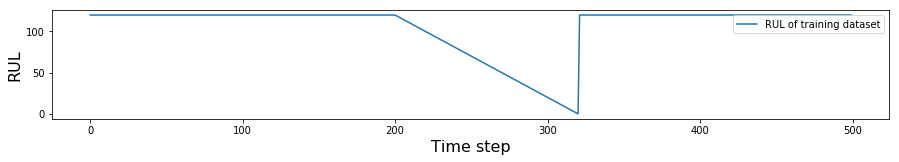

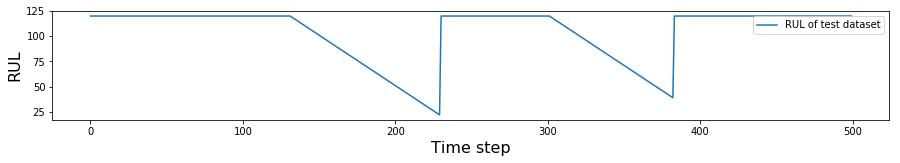

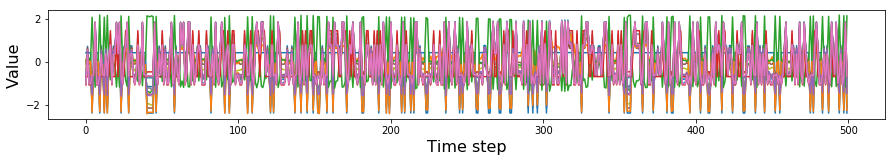

In [33]:
training_data = train_FD.values
testing_data = test_FD.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
# print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
# print("testing", x_test.shape, y_test.shape)

plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="RUL of training dataset")
plt.ylabel("RUL")
plt.xlabel("Time step")
plt.legend()
plt.figure(figsize=(15,2))

plt.plot(y_test[:500], label="RUL of test dataset")
plt.ylabel("RUL")
plt.xlabel("Time step")
plt.legend()

plt.figure(figsize=(15,2))
plt.plot(x_train[:500], label="All sensor values from training dataset")
plt.ylabel("Value")
plt.xlabel("Time step")


plt.show()

# Data Batch generation
    
Data generation with sliding window method
![title](image/sliding.png)

Before training data can be generated, two parameters need to be defined

**sequence length** defines the number of steps the window moves

**Window size** defines the number of time steps included in the window

In the figure above, the window size is 4, which has moved one step

**These two hyper-parameters need to be optimized**


In [34]:
sequence_length=5
window_size = 16
# Prepare the training set according to the  window size and sequence_length

x_batch, y_batch =batch_generator(train_FD,sequence_length=sequence_length,window_size = window_size)

x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

feature = x_batch.shape[3] # number of used sensors


# Model

One neural network model, called FCLSTM, was taken from [[3]](https://ieeexplore.ieee.org/document/7998311), which is often cited as a baseline by other related works on this dataset. We also chose it as a baseline for comparison.

The network (named as FCLSTM) in work [[3]](https://ieeexplore.ieee.org/document/7998311) has a five-layer architecture. 
   - The first layer is a LSTM layer with 32 hidden nodes. 
   - The second layer is the same, but contains 64 hidden nodes. 
   - The third and fourth layers are forward fully connected layers, each with 8 hidden nodes. 
   - The last layer is a 1-dimensional output layer which predicts the RUL.

The following table shows how the performance of FCLSTM on this data. Evaluation Metric is RMSE. Note that the window size was set as **one** in the original paper.

| Data Set | FD001 | FD002 | FD003      | FD001                             |
|:----------:|:-------:|:----------:|:-----------:|:----------------:|
| MLP [[2]](https://link.springer.com/chapter/10.1007/978-3-319-32025-0_14)   |  37.56   |  80.03 | 37.39 | 77.37    |
| SVR [[2]](https://link.springer.com/chapter/10.1007/978-3-319-32025-0_14)   |  20.96   |  42.00 | 21.05 | 45.35    |
| RVR  [[2]](https://link.springer.com/chapter/10.1007/978-3-319-32025-0_14)  |  23.80   |  31.30 | 22.37 | 34.34 |
| CNN  [[2]](https://link.springer.com/chapter/10.1007/978-3-319-32025-0_14)  |  18.45   |  30.29 | 19.82 | 29.16 |
| FCLSTM  [[3]](https://ieeexplore.ieee.org/document/7998311)   | **16.14**|  **24.49** | **16.18**  |**28.17**|




To validate whether the ECLSTM can improve performance, We applied a similar structure to the former. The difference from the former network is that the first and second layers are replaced by 2-depth-ECLSTM layer. The hyper-parameters (convolution kernel size and filters number) in ECLSTM layers are determined by simple rules. They are not optimized.

The model (named as ECLSTM) has also a five-layer architecture. 
- The first layer is a ECLSTM layer with 10 filters, and the kernel size is 3.
- The second layer is a ECLSTM layer with 10 filters, and the kernel size is 3.
- The third and fourth layers are forward fully connected layers, each with 8 hidden nodes. 
- The last layer is a 1-dimensional output layer which predicts the RUL.

In [35]:
# specify the achtecture parameters
#  This Model consists of three parts, namely the pre-processing, feature extraction and RUL prediction parts.
para = {
    # preprocessing part
    #   If the number of layers (preprocessing_layers) is defined as 0, it means that no pre-processing is performed
    "preprocessing_layers" : 0,
    "pre_kernel_width" : 3,
    "pre_number_filters" : 10,
    "pre_strides" : 2,
    "pre_activation" : "relu",


    # ECLSTM feature extraction part
    # here shows 2 depth ECLSTM
    "eclstm_1_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_1_conv_activation" : ['hard_sigmoid',"hard_sigmoid"],
    "eclstm_1_kernel_width" : [3,3],
    "eclstm_1_number_filters" : [10,10],
    "eclstm_1_strides" : 1,
    "eclstm_1_fusion":["early","early"],
    
    "eclstm_2_recurrent_activation" : ['linear',"hard_sigmoid"],
    "eclstm_2_conv_activation" : ['hard_sigmoid',"hard_sigmoid"],
    "eclstm_2_kernel_width" : [3,3],
    "eclstm_2_number_filters" : [10,10],
    "eclstm_2_strides" : 1,
    "eclstm_2_fusion":["early","early"],

    "eclstm_3_recurrent_activation" : [None],
    "eclstm_3_conv_activation" : [None],
    "eclstm_3_kernel_width" : [None],
    "eclstm_3_number_filters" : [None],
    "eclstm_3_strides" : None,
    "eclstm_3_fusion":[None],

    "eclstm_4_recurrent_activation" : [None],
    "eclstm_4_conv_activation" : [None],
    "eclstm_4_kernel_width" : [None],
    "eclstm_4_number_filters" : [None],
    "eclstm_4_strides" : None,
    "eclstm_4_fusion":[None],

    # Prediction
    "prediction_1_filters" : 8,
    "prediction_1_activation" : "relu",
    
    "prediction_2_filters" : 8,
    "prediction_2_activation" : "relu",
    
    "prediction_3_filters" : 0,
    "prediction_3_activation" : None,
    
    "prediction_4_filters" : 0,
    "prediction_4_activation" : None,
}

In [36]:
# All padding in the convolution in the model is set to valid, which can cause illegal operations 
# if the kernel size, strides are too large
valid_flag = check_the_config_valid(para, window_size,feature)    

In [37]:
ECLSTM_model = build_the_model(para, sequence_length, window_size, feature)
input_ = keras.layers.Input(shape=(sequence_length, window_size, feature,1))
output_ = ECLSTM_model(input_)
print(ECLSTM_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
eclst_m1d_2 (ECLSTM1D)       (None, 5, 12, 1, 10)      6020      
_________________________________________________________________
batch_normalization_2 (Batch (None, 5, 12, 1, 10)      40        
_________________________________________________________________
eclst_m1d_3 (ECLSTM1D)       (None, 8, 1, 10)          5180      
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 1, 10)          40        
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 648       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                

In [38]:
# if you have enough time budget, you can set a large epochs and large patience
logging = callback.TensorBoard()
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,  mode='min')
mcp_save = callback.ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
ECLSTM_model.fit(x_batch,y_batch, batch_size=15, epochs=20, callbacks=[EarlyStopping, mcp_save],validation_split=0.075)

Train on 52279 samples, validate on 4239 samples
Epoch 1/20
52279/52279 [==============================] - 126s 2ms/sample - loss: 786.9833 - val_loss: 516.0271
Epoch 2/20
52279/52279 [==============================] - 121s 2ms/sample - loss: 451.6268 - val_loss: 1269.2656
Epoch 3/20
52279/52279 [==============================] - 119s 2ms/sample - loss: 423.6102 - val_loss: 1431.5643
Epoch 4/20
52279/52279 [==============================] - 119s 2ms/sample - loss: 404.9991 - val_loss: 447.0276
Epoch 5/20
52279/52279 [==============================] - 119s 2ms/sample - loss: 393.4501 - val_loss: 721.1560
Epoch 6/20
52279/52279 [==============================] - 119s 2ms/sample - loss: 373.7842 - val_loss: 429.1485
Epoch 7/20
52279/52279 [==============================] - 119s 2ms/sample - loss: 349.7446 - val_loss: 406.1904
Epoch 8/20
52279/52279 [==============================] - 119s 2ms/sample - loss: 335.5538 - val_loss: 370.3029
Epoch 9/20
52279/52279 [=============================

# Evaluation

##  Performance on training dataset

In [39]:
y_batch_pred = ECLSTM_model.predict(x_batch)

y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
rmse_on_train = np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

print("The RMSE of ECLSTM_model on training dataset {} is {}.".format(Data_id,rmse_on_train))

The RMSE of ECLSTM_model on training dataset FD004 is 17.370271682739258.


##  Performance on test dataset

In [40]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [41]:
ECLSTM_model.load_weights('best_model.h5')

# reload trained model
# ECLSTM_model.load_weights('trained_model/best_model_{}.h5'.format(Data_id))

y_batch_pred_test = ECLSTM_model.predict(x_batch_test)
rmse_on_test = np.sqrt(mean_squared_error(y_batch_pred_test, y_batch_test))
print("The RMSE on test dataset {} is {}.".format(Data_id,rmse_on_test))

The RMSE on test dataset FD004 is 19.566816329956055.


#### <font color=red>**This model is not optimized， But it has been able to achieve state of the art results on FD002 and FD004 dataset.  And the performance on FD001 and FD002 dataset is also better than the optimized traditional LSTM model.**</font>

| Methods | FD001 | FD002 | FD003      | FD004       |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| DCNN   |   12.61   |  22.36   | 12.64 |  23.31  |
| DAG   |   11.96   | 20.34  |   12.46  |  22.43 |   
| AdaBN  |   **11.94**   |  19.29  |   **12.31**    |  22.14  | 
| not optimized Model  |   14.92  |  **17.11**  |  13.85    | **19.01** |     

# potential



* The model above is not optimized, If the model is optimized separately for each data set, the results will be better.

    
    
* How to effectively set these hyperparameters? automated machine learning or Hyperparameter tuning

